In [9]:
from pathlib import Path
from typing import Iterable

import torch
import torch.nn as nn

from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from commons import DEVICE, DATA_DIR, MODEL_DIR, Batch, IndexedDataset
from influence import get_influences
from models import make_mlp

In [2]:
RUN_NAME: str = "MNIST-10-epochs"

# MNIST dataset
IN_FEATURES: int = 28 * 28
OUT_FEATURES: int = 10

# model architecture
HIDDEN_FEATURES: int = 128
NUM_HIDDEN_LAYERS: int = 4

BATCH_SIZE: int = 32

In [3]:
def get_models(run_name: str) -> Iterable[nn.Module]:
    models_dir = Path(f"{MODEL_DIR}/{run_name}/")
    checkpoints = [f for f in models_dir.iterdir()]
    sorted_checkpoints = sorted(checkpoints, key=lambda f: int(f.stem))
    for checkpoint in sorted_checkpoints:
        mlp = make_mlp(
            in_features=IN_FEATURES,
            out_features=OUT_FEATURES,
            hidden_features=HIDDEN_FEATURES,
            num_hidden_layers=NUM_HIDDEN_LAYERS,
        )
        state_dict = torch.load(checkpoint)
        mlp.load_state_dict(state_dict)
        model = nn.Sequential(
            Rearrange("b c h w -> b (c h w)"),
            mlp,
        ).to(device=DEVICE)
        yield model

In [4]:
train_dataset = IndexedDataset(
    MNIST(
        root=f"{DATA_DIR}",
        train=True,
        transform=ToTensor(),
        download=True,
    )
)
test_dataset = IndexedDataset(
    MNIST(
        root=f"{DATA_DIR}",
        train=False,
        transform=ToTensor(),
        download=True,
    )
)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_indexes, train_inputs, train_targets = next(iter(train_dataloader))
test_indexes, test_inputs, test_targets = next(iter(test_dataloader))

train_indexes = train_indexes.to(device=DEVICE)
train_inputs = train_inputs.to(device=DEVICE)
train_targets = train_targets.to(device=DEVICE)
test_indexes = test_indexes.to(device=DEVICE)
test_inputs = test_inputs.to(device=DEVICE)
test_targets = test_targets.to(device=DEVICE)

train_batch = Batch(
    indices=train_indexes,
    inputs=train_inputs,
    targets=train_targets,
)
test_batch = Batch(
    indices=test_indexes,
    inputs=test_inputs,
    targets=test_targets,
)

In [5]:
influences = get_influences(
    models=get_models(RUN_NAME),
    train_samples=train_batch,
    test_samples=test_batch,
    loss_fn_name="cross-entropy",
    device=DEVICE,
)

In [24]:
import matplotlib.pyplot as plt

from einops import rearrange
from matplotlib.gridspec import GridSpec
from matplotlib.colors import CenteredNorm

from commons import Array, Float


def visualize_influence_images(
    train_images: Float[Array, "n_train c h w"],
    test_images: Float[Array, "n_test c h w"],
    influences: Float[Array, "n_train n_test"],
):
    n_train, *_ = train_images.shape
    n_test, *_ = test_images.shape

    fig = plt.figure(figsize=(n_test + 1, n_train + 1))

    gs = GridSpec(
        nrows=(n_train + 1),
        ncols=(n_test + 1),
        width_ratios=([1] * n_test + [0.05]),
        wspace=0.5,
        hspace=0.5,
    )

    for train_index, train_image in enumerate(train_images):
        ax = fig.add_subplot(gs[train_index + 1, 0])
        ax.imshow(rearrange(train_image, "c h w -> h w c"), cmap="gray")
        ax.axis("off")

    for test_index, test_image in enumerate(test_images):
        ax = fig.add_subplot(gs[0, test_index + 1])
        ax.imshow(rearrange(test_image, "c h w -> h w c"), cmap="gray")
        ax.axis("off")

    ax = fig.add_subplot(gs[1:, 1:-1])
    cax = ax.matshow(influences, cmap="bwr", norm=CenteredNorm())
    ax.axis("off")

    plt.show()


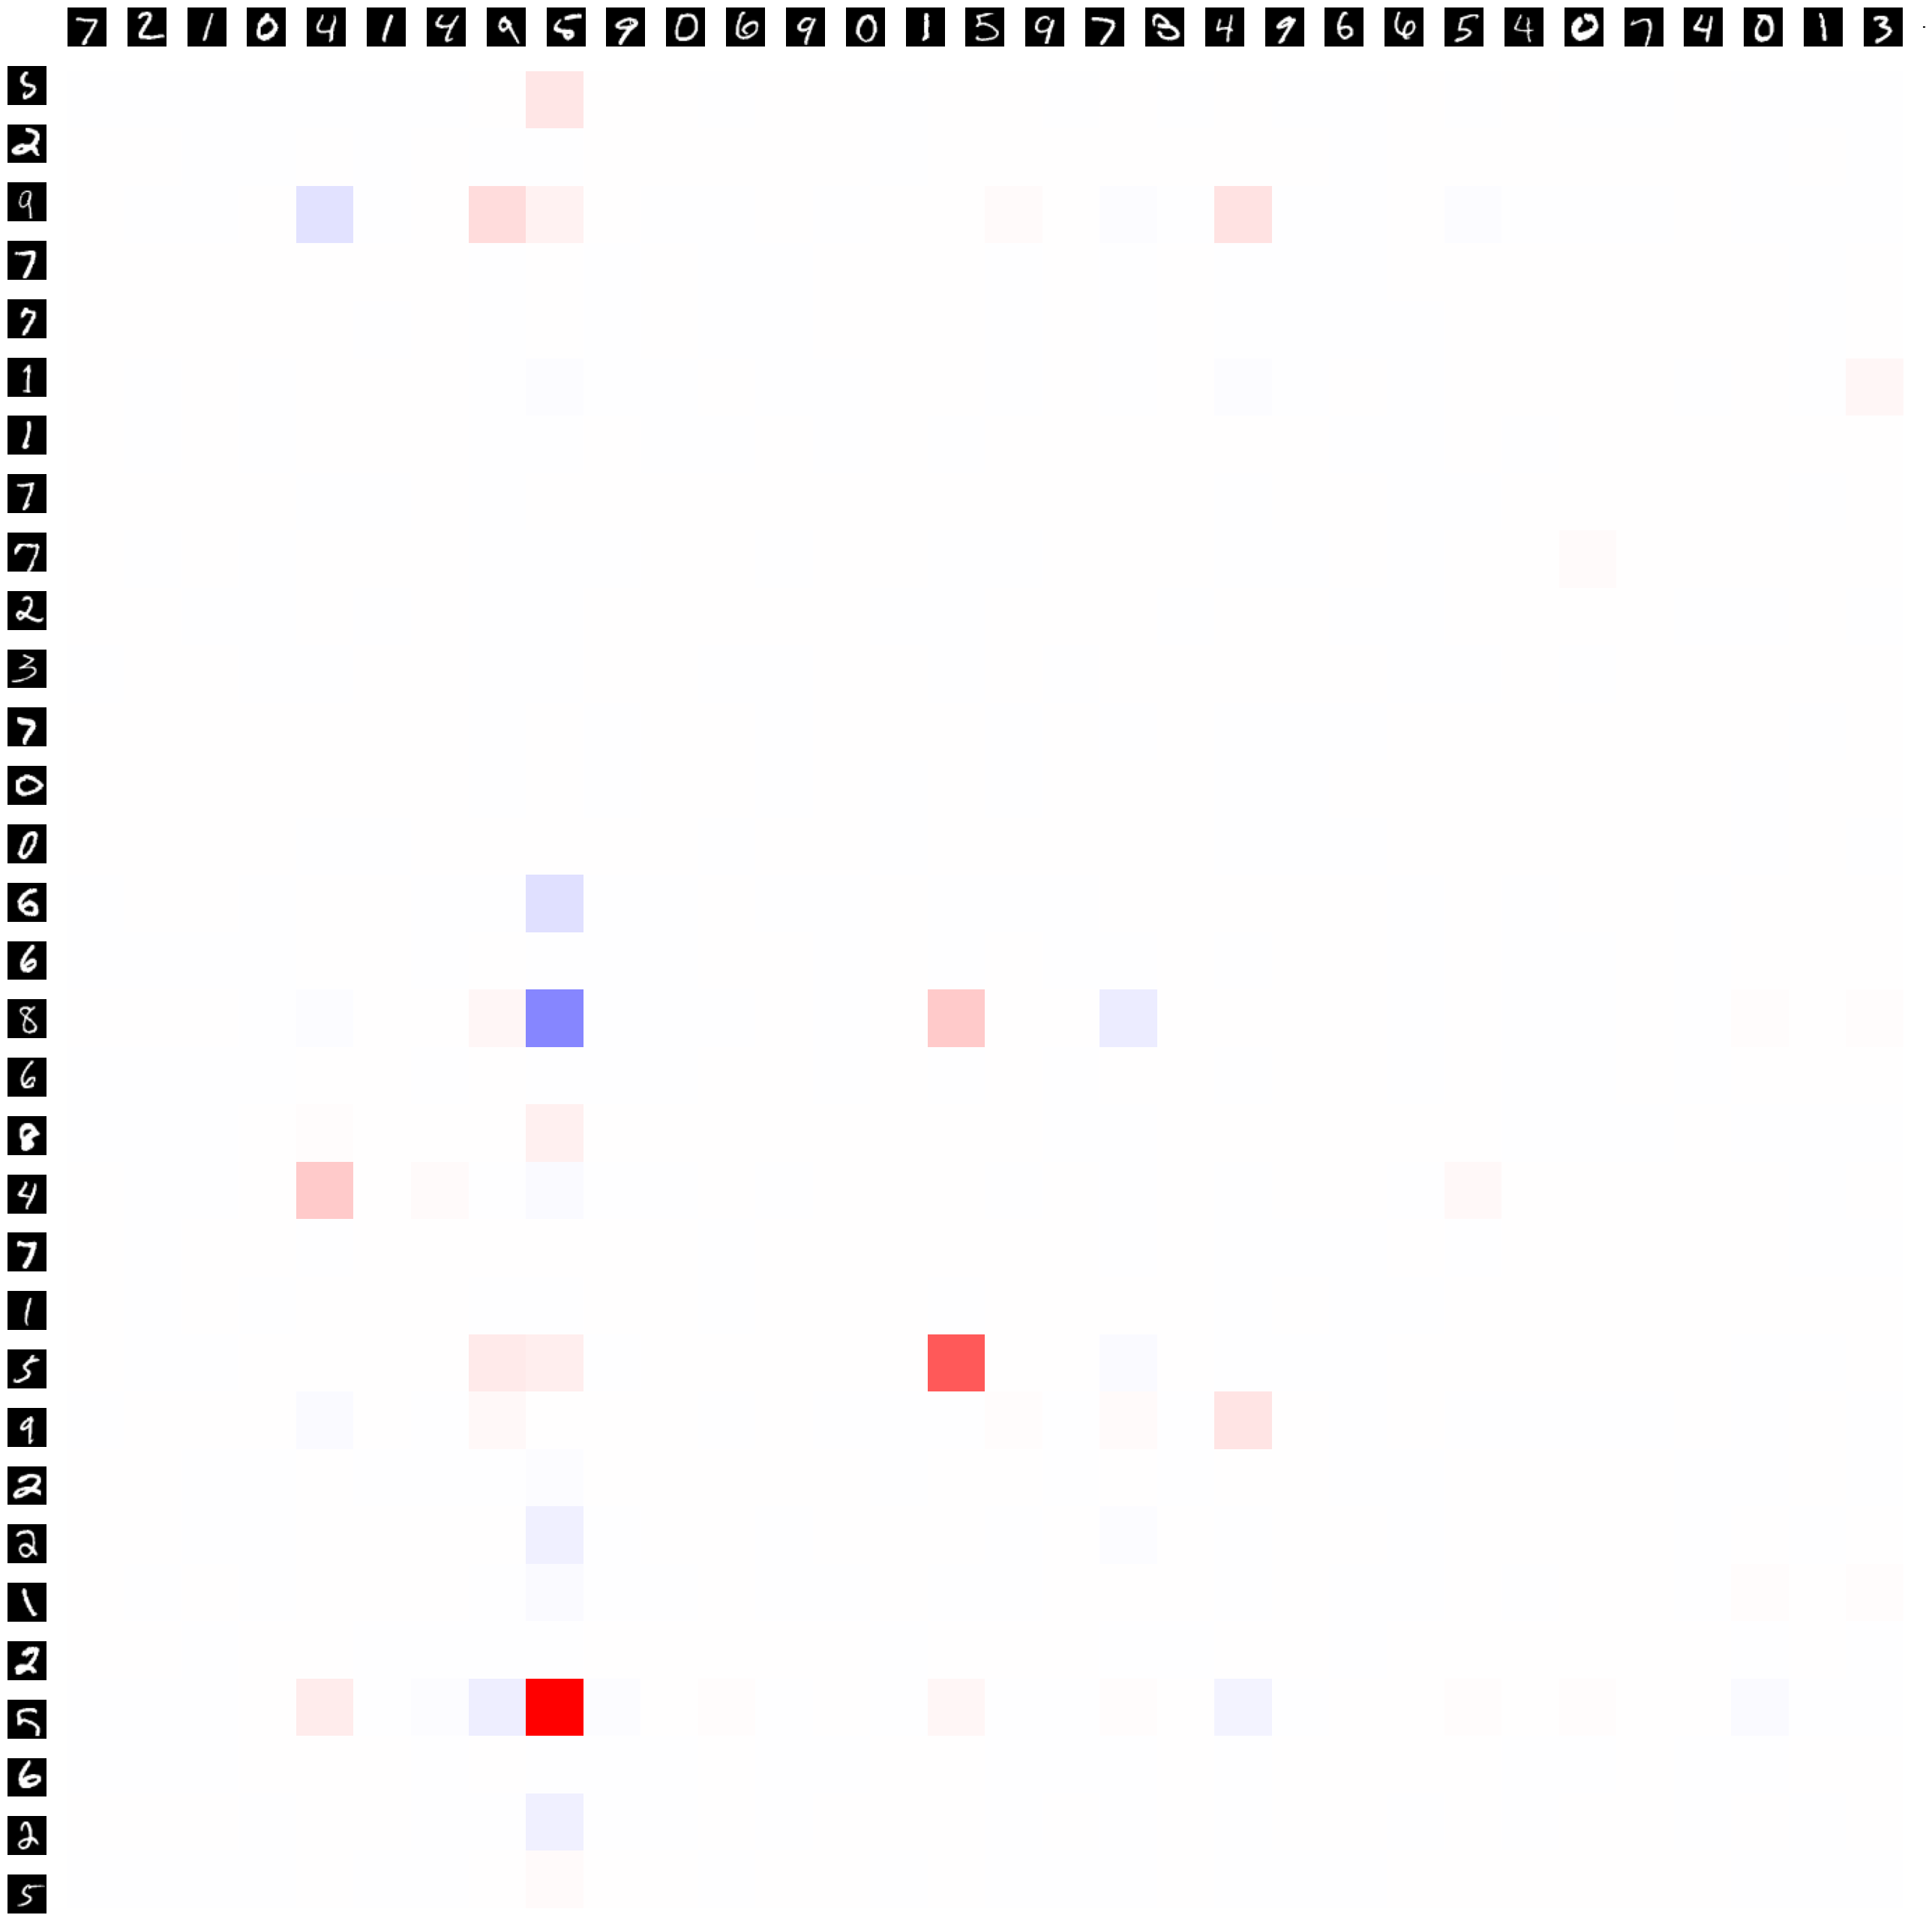

In [25]:
visualize_influence_images(train_inputs.cpu(), test_inputs.cpu(), influences.cpu())